# KoBERT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch

print(torch.__version__)

print('gpu' if torch.cuda.is_available() else 'cpu')

2.1.0+cu118
gpu


# 라이브러리 설치

In [3]:
# 현재 github에 있는 kobert 라이브러리가 제공되지 않으므로 설치해야 함
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers

In [4]:
# github 내 파일을 코랩으로 가져오기
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-o92qp628/kobert-tokenizer_6b6668e82d6e484aaf3d10138fde4da6
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-o92qp628/kobert-tokenizer_6b6668e82d6e484aaf3d10138fde4da6
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


# Import

In [5]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [6]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

# 데이터셋 토큰화

In [8]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [10]:
dataset_train = nlp.data.TSVDataset("/content/drive/MyDrive/python/bax/bax_bmc_use/USB/lstm_text_classification/create_data/add_all_train_v5.txt", field_indices=[2, 3], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("/content/drive/MyDrive/python/bax/bax_bmc_use/USB/lstm_text_classification/create_data/add_all_test_v5.txt", field_indices=[2, 3], num_discard_samples=1)

In [11]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# 파라미터 세팅

In [12]:
max_len = 128
batch_size = 16
warmup_ratio = 0.1
num_epochs = 15
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [14]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# KoBERT 모델 구현

In [15]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# Optimizer 설정

In [16]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [17]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [18]:
# optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [19]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# Model Training

In [20]:
# 각 epoch에 대한 훈련 및 테스트 정확도를 저장할 리스트
train_accuracy_values = []
test_accuracy_values = []

# 각 epoch에 대한 훈련 및 테스트 손실을 저장할 리스트
train_loss_values = []
test_loss_values = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    test_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.item()
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e + 1, batch_id + 1, loss.data.cpu().numpy(),
                                                                     train_acc / (batch_id + 1)))

    print("epoch {} train acc {}".format(e + 1, train_acc / (batch_id + 1)))
    # 시각화를 위한 append
    train_accuracy_values.append(train_acc / (batch_id + 1))
    train_loss_values.append(train_loss / (batch_id + 1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        test_loss += loss_fn(out, label).item()

    print("epoch {} test acc {}".format(e + 1, test_acc / (batch_id + 1)))

    # 시각화를 위한 append
    test_accuracy_values.append(test_acc / (batch_id + 1))
    test_loss_values.append(test_loss / (batch_id + 1))

<ipython-input-20-9abbab9f150f>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/474 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1 batch id 1 loss 1.658244252204895 train acc 0.25
epoch 1 batch id 201 loss 1.170069932937622 train acc 0.3697139303482587
epoch 1 batch id 401 loss 0.6972877383232117 train acc 0.543640897755611
epoch 1 train acc 0.584802591922845


<ipython-input-20-9abbab9f150f>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 1 test acc 0.805672268907563


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.7788947820663452 train acc 0.5625
epoch 2 batch id 201 loss 0.5279874801635742 train acc 0.7953980099502488
epoch 2 batch id 401 loss 0.7259706854820251 train acc 0.7995635910224439
epoch 2 train acc 0.8007836045810729


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 2 test acc 0.7485994397759104


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.903376579284668 train acc 0.625
epoch 3 batch id 201 loss 0.6760479807853699 train acc 0.7991293532338308
epoch 3 batch id 401 loss 0.621914267539978 train acc 0.7955112219451371
epoch 3 train acc 0.79709162145871


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 3 test acc 0.8203781512605042


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7114155292510986 train acc 0.6875
epoch 4 batch id 201 loss 0.6211498379707336 train acc 0.7829601990049752
epoch 4 batch id 401 loss 0.45848751068115234 train acc 0.7914588528678305
epoch 4 train acc 0.7929098854731766


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 4 test acc 0.8272058823529411


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6000964641571045 train acc 0.75
epoch 5 batch id 201 loss 0.5235813856124878 train acc 0.7761194029850746
epoch 5 batch id 401 loss 0.5765355825424194 train acc 0.7866271820448878
epoch 5 train acc 0.7895192887281495


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 5 test acc 0.728641456582633


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.6843520402908325 train acc 0.625
epoch 6 batch id 201 loss 0.46691715717315674 train acc 0.8118781094527363
epoch 6 batch id 401 loss 0.5425794124603271 train acc 0.8076683291770573
epoch 6 train acc 0.8092600964436407


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 6 test acc 0.8235294117647058


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.6472375988960266 train acc 0.6875
epoch 7 batch id 201 loss 0.4940343201160431 train acc 0.8118781094527363
epoch 7 batch id 401 loss 0.5004352331161499 train acc 0.815149625935162
epoch 7 train acc 0.8150241109101868


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 7 test acc 0.8413865546218487


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.49223610758781433 train acc 0.625
epoch 8 batch id 201 loss 0.4902641773223877 train acc 0.8264925373134329
epoch 8 batch id 401 loss 0.47126686573028564 train acc 0.8246571072319202
epoch 8 train acc 0.8257421639541893


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 8 test acc 0.8345588235294118


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.5736832022666931 train acc 0.6875
epoch 9 batch id 201 loss 0.5195510387420654 train acc 0.8308457711442786
epoch 9 batch id 401 loss 0.5597851276397705 train acc 0.8269950124688279
epoch 9 train acc 0.8291704339963833


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 9 test acc 0.8345588235294118


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.5634750723838806 train acc 0.8125
epoch 10 batch id 201 loss 0.5197009444236755 train acc 0.837997512437811
epoch 10 batch id 401 loss 0.43014252185821533 train acc 0.8329177057356608
epoch 10 train acc 0.8360269740807715


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 10 test acc 0.8419117647058824


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.6387659311294556 train acc 0.6875
epoch 11 batch id 201 loss 0.45592936873435974 train acc 0.835820895522388
epoch 11 batch id 401 loss 0.468304306268692 train acc 0.839931421446384
epoch 11 train acc 0.8405666063893912


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 11 test acc 0.8371848739495799


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.5302932262420654 train acc 0.75
epoch 12 batch id 201 loss 0.448555052280426 train acc 0.8420398009950248
epoch 12 batch id 401 loss 0.42229893803596497 train acc 0.8458541147132169
epoch 12 train acc 0.8480259192284509


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 12 test acc 0.8455882352941176


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.44620704650878906 train acc 0.8125
epoch 13 batch id 201 loss 0.4676317274570465 train acc 0.8504353233830846
epoch 13 batch id 401 loss 0.4549543559551239 train acc 0.8511533665835411
epoch 13 train acc 0.8519439421338155


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 13 test acc 0.8434873949579832


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.5093907117843628 train acc 0.75
epoch 14 batch id 201 loss 0.4648360013961792 train acc 0.8488805970149254
epoch 14 batch id 401 loss 0.40578657388687134 train acc 0.8542705735660848
epoch 14 train acc 0.8558054550934298


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 14 test acc 0.8455882352941176


  0%|          | 0/474 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.545462965965271 train acc 0.8125
epoch 15 batch id 201 loss 0.5615354180335999 train acc 0.8510572139303483
epoch 15 batch id 401 loss 0.5017156004905701 train acc 0.856140897755611
epoch 15 train acc 0.8581411995177818


  0%|          | 0/119 [00:00<?, ?it/s]

epoch 15 test acc 0.8461134453781513


# 시각화

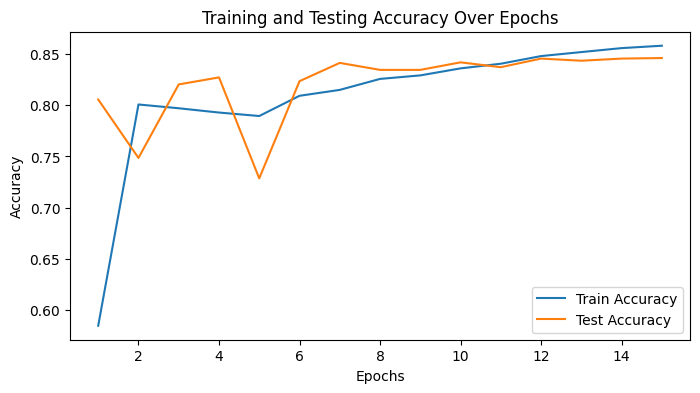

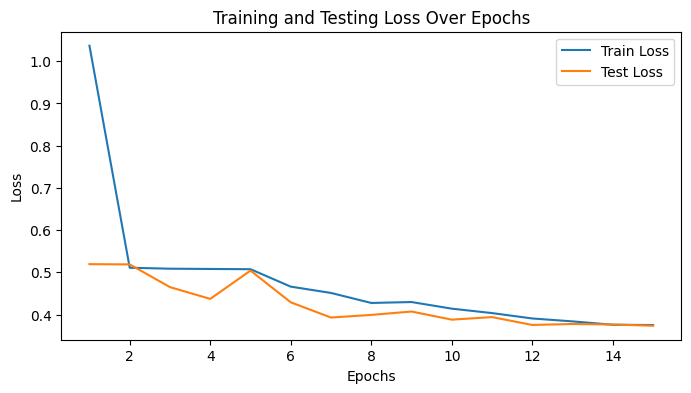

In [21]:
# 훈련 및 테스트 정확도 그래프
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_accuracy_values, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

# (옵션) 훈련 및 테스트 손실 그래프
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_loss_values, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Over Epochs')
plt.show()

# 모델 저장

In [26]:
## 학습 모델 저장
PATH = '/content/drive/MyDrive/python/bax/bax_bmc_use/USB/lstm_text_classification/save_model/'
torch.save(model, PATH + 'add_all_data_v5.pt')
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능